In [2]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

# Selecting optimal biases for BAMS
This notebook outlines a way to provide maximally informative biases in the iterative BAMS procedure. For a reference of the general approaches, see https://en.wikipedia.org/wiki/Optimal_design.

## Two state state system
The likelihood for the state counts is the binomial distribution, which, for $n$ success out of $N$ samples given by 

$$ f(n | \Delta f, \zeta) \propto p(\Delta f, \zeta)^n \, (1 - p(\Delta f, \zeta))^{N - n}$$

where

$$ p(\Delta f, \zeta) = \frac{1}{1 + \exp(\Delta f - \zeta)} $$

which is the logisitic function.

If $\Delta f$ is the unknown parameter of interest, and we can sample from $f(n | \Delta f, \zeta)$ at any value of $\zeta$ we want, what value of $\zeta$ should one choose to sample from in order to obtain the best estimate of $\Delta f$? There are a number of ways to approach this problem. In this notebook, I will consider choosing $\zeta$ to 1. minimize the expected variance and 2. maximize the gain in information. 

## 1. Pick  $\zeta$ to minimize the expected variance in $\Delta f$
For this route, we require an expression for the variance of $\Delta f$ as a function of $\zeta$. One approach is the exploit the Cramer-Rao lower bound for the variance of $\Delta f$:

$$ \text{Var}(\Delta f|\zeta) \geq \frac{1}{I(\Delta f|\zeta)} $$

where $I(\Delta f|\zeta)$ is the Fischer information of $f(n | \Delta f, \zeta)$, and is given by

$$ I(\Delta f|\zeta) = \mathop{\mathbb{E}} \left [ \left (\frac{\partial}{\partial \Delta f }\log(f(n | \Delta f, \zeta)) \right)^2\right]$$

After a some alegrebra, this can be shown to be

$$ I(\Delta f|\zeta) = \frac{N}{p(\Delta f, \zeta)(1-p(\Delta f, \zeta))}$$

such that

$$\text{Var}(\Delta f|\zeta) \geq \frac{p(\Delta f, \zeta)(1-p(\Delta f, \zeta))}{N} $$

The lower bound has the form $x(1-x)$, $0 \leq x \leq 1$ , which, by inspection, has a maximum at x=0.5. This implies that the variance is maximized at $\zeta = \Delta f$ because $p(\Delta f, \zeta)$ is the logistic function. To confirm this, we can see what this looks like by plotting the Cramer-Rao lower bound as a function of $\zeta$.

Defining a couple of functions will be defined first:

In [3]:
def logistic(f, zeta):
    """
    The logistic function, which is the probability for observing one success in the above model. 
    """
    return 1/(1 + np.exp(f - zeta))

def logistic_pdf(f, zeta, s=1):
    """
    The pdf of logistic distribution, for comparison to the lower bound to the variance.
    """
    numerator = np.exp((f - zeta)/s)
    denominator = s*((1 + np.exp((f - zeta)/s))**2)
    return numerator / denominator
    
def var_lower_bound(f,zeta,N=10):
    """
    The Cramer Rao lower bound of the variance in the binomial likelihood.
    """
    return logistic(f, zeta)*(1 - logistic(f, zeta))/N

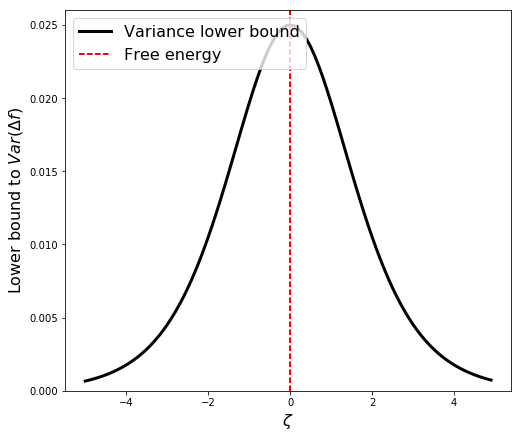

In [13]:
# Defining the parameters:
f = 0
N = 10
zetas = np.arange(-5, 5,0.1)

# Calculating the Cramer-Rao lower bound
v = var_lower_bound(f=f, zeta = zetas,N=N)
density = logistic_pdf(f, zetas, s=1)
density = density/density.max()*v.max()

# Plotting
plt.figure(figsize=(8,7))
plt.plot(zetas, v, lw=3, color='k', label='Variance lower bound')
#plt.plot(zetas, density, lw=1, color='grey', ls='--', label='logistic pdf')
plt.axvline(f, color='red', lw=2, ls='--', label='Free energy')
plt.ylim((0, np.max(v)+0.01/N ))
plt.ylabel('Lower bound to $Var(\Delta f)$', fontsize = 16)
plt.xlabel('$\zeta$', fontsize = 16)
plt.legend(fontsize=16, loc=2)
plt.show()

This confirms the assertion above that the variance is at a maximum when $\Delta f = \zeta$. An interesting feature about the variance lower bound has exactly the same shape as the logistic pdf. That is what I used prior to the above derivation.

### Optimal samples from maximum variance
Returing the central question, where should one sample from in order to minimize the uncertainty in $\Delta f$? In other words, which samples decrease the variance the most? With the estimate for the variance given by the Cramer-Rao lower bound, we can see the rate of change of the varaince with respect to samples is given by

$$ \frac{\partial \text{Var}(\Delta f|\zeta) }{\partial N} \geq -\frac{1}{N} \text{Var}(\Delta f|\zeta)$$

The most important aspect of this equation is that it is negative with respect to samples: the more samples one draws, the more the variance decrases. 

For a fixed $N$, samples drawn from the value of $\zeta$ that maximises ${Var}(\Delta f|\zeta)$ decrease the variance the most due to the minus sign. Samples drawn from any other value of $\zeta$ will have a lower gradient in the variance. Therefore, for a fixed $N$, the choice of $\zeta$ that maximimises the expected decrease in the variance of $\Delta f$ can be expressed as

$$ \zeta^* = \text{argmax}_\zeta \text{Var}(\Delta f|\zeta) $$

which for the example above, $\zeta^*=\Delta f$. 

## 2. Pick $\zeta$ to maximize the information gain

#### ROUGH DRAFT
For the $i+1$th iteration of the algorithm, the updated posterior is given by

$$ p(\Delta f| \zeta_{i+1}, n_{i+1}) \propto p(n_{i+1}|\Delta f, \zeta_{i}) p(\Delta f| \zeta_{i}, n_{i}) $$

for the set of counts for $(n_1,n_2,...)$ and biases $(\zeta_1,\zeta_2,...)$ at each iteration.

The goal is to select $\zeta_{i+1}$ so as to maximise the gain in information. This can be achieved by picking

$$ \zeta_{i+1} = \text{argmax}_\zeta \, D( p(\Delta f| \zeta, n_{i+1}) \, || \,p(\Delta f| \zeta_{i}, n_{i})) $$

where $D( p(\Delta f| \zeta_{i+1}, n_{i+1}) \, || \,p(\Delta f| \zeta_{i}, n_{i}))$ is the Kullback–Leibler divergence of the updates posterior with the posterior of the previous iteration. It is given by

$$D( p(\Delta f| \zeta_{i+1}, n_{i+1}) \, || \,p(\Delta f| \zeta_{i}, n_{i})) = ...$$

This choice can be shown to be [I think] picking $\zeta$ to maximise the entropy of the likelihood.